# **Language Learning on Duolingo: *Patterns from the Data***

## Introduction
Duolingo is a popular language-learning platform that offers courses in 43 language (both real and fictional) to over 500 million users. The app uses games and quizzes to teach the learner vocabulary, grammar, and pronunciation.

The data used in this analysis was collected through a web scrape of [this website](https://duolingodata.com). 

To better organise the data, I created an SQLite database where each table corresponds to a unique origin language.

I am interested in determining how language popularity based on origin, as well as how the design of the course affects the number of learners.

### *Importing Data and Libraries*

In [126]:
import sqlite3
import pandas as pd
import os
import matplotlib.pyplot as plt

base_dir = os.getcwd()
db_path = os.path.join(base_dir, 'data', 'duolingoDatabase.db')
image_path = os.path.join(base_dir, 'images')

conn = sqlite3.connect(db_path)
query = """
SELECT
    a.id,
    a.learning,
    o.origin_name AS origin,
    a.u,
    a.lr,
    a.ls,
    a.s,
    a.w,
    a.r,
    a.d,
    a.cefr
FROM all_data a
JOIN origins o ON a.origin_id = o.id
"""
df = pd.read_sql_query(query, conn)


origins_df = pd.read_sql_query('SELECT origin_name, language_name, countries FROM origins', conn)
conn.close()
print(df.head())
print(origins_df.head())

   id learning origin    u     lr    ls  s     w      r    d cefr
0   1   Arabic     EN   46   8.56   798  0  1519  24.05   46     
1   2  Chinese     EN   70  11.90  1276  0  2006  25.03   70   A1
2   4    Czech     EN   88   1.00  1592  0  2696  24.05   88     
3   5   Danish     EN   62   1.11  1004  0  2341  24.05   62     
4   6    Dutch     EN  123   3.37  2039  0  2995  24.05  123     
  origin_name language_name                                          countries
0          AR        Arabic  Egypt, Saudi Arabia, Iraq, Jordan, United Arab...
1          BN       Bengali                                         Bangladesh
2          CS         Czech                                     Czech Republic
3          DE        German  Germany, Austria, Switzerland, Liechtenstein, ...
4          EL         Greek                                     Greece, Cyprus


## Global Language Popularity

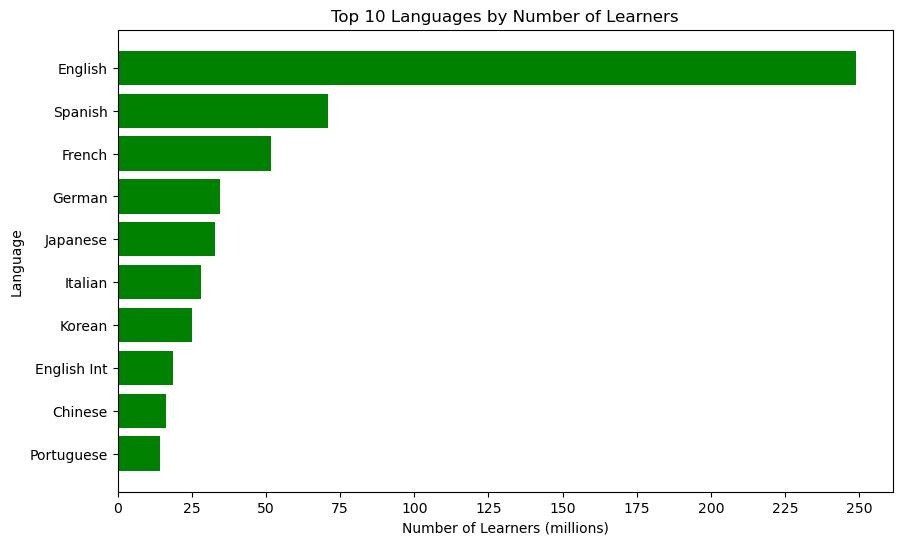

In [117]:
# Getting the top 10 languages by number of learners
top_10_languages = df.groupby("learning")["lr"].sum().sort_values(ascending=False).head(10).iloc[::-1]

# Plotting the top 10 languages
plt.figure(figsize=(10, 6))
plt.barh(top_10_languages.index, top_10_languages.values, color="green")

plt.xlabel("Number of Learners (millions)")
plt.ylabel("Language")
plt.title("Top 10 Languages by Number of Learners")
plt.xticks(range(0,275,25))

plt.savefig(os.path.join(image_path, "top_10_languages.png"))
plt.show()



This graph shows the number of learners for each language. With 250 million learners, English is the most popular language. Spanish and French are the second and third most popular languages. This is as expected, as all origin languages on Duolingo allow users to learn English. 

Interstingly, the total number of learners with English as there origin language is 263.36 million (from dataInvestigation.sql), this is similar to the number of learners learning English as a target language (250 million). This suggests that the majority of users on Duolingo can speak English, either as a first or second language.

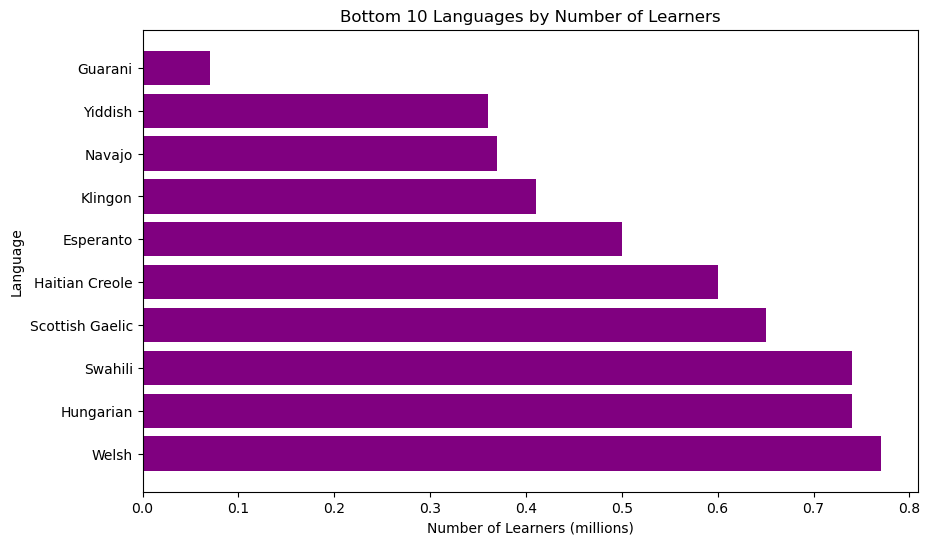

In [118]:
# Getting the bottom 10 languages by number of learners
bottom_10_languages = df.groupby("learning")["lr"].sum().sort_values(ascending=True).head(10).iloc[::-1]

# Plotting the bottom 10 languages
plt.figure(figsize=(10, 6))
plt.barh(bottom_10_languages.index, bottom_10_languages.values, color='purple')
plt.title('Bottom 10 Languages by Number of Learners')
plt.xlabel('Number of Learners (millions)')
plt.ylabel('Language')

plt.savefig(os.path.join(image_path, "bottom_10_languages.png"))

plt.show()



The language with the fewest learners is Guarani (spoken in Paraguay), with less than 100,000 learners. This may be because this course is only offered to Spanish speakers. The other least learnt languages include fictional languages, such as Klingon as well as regional languages, such as Welsh and Scottish Gaelic. 

Most of the least learnt languages are only offered to English speakers. This may be because these languages are not widely spoken outside of their native countries.

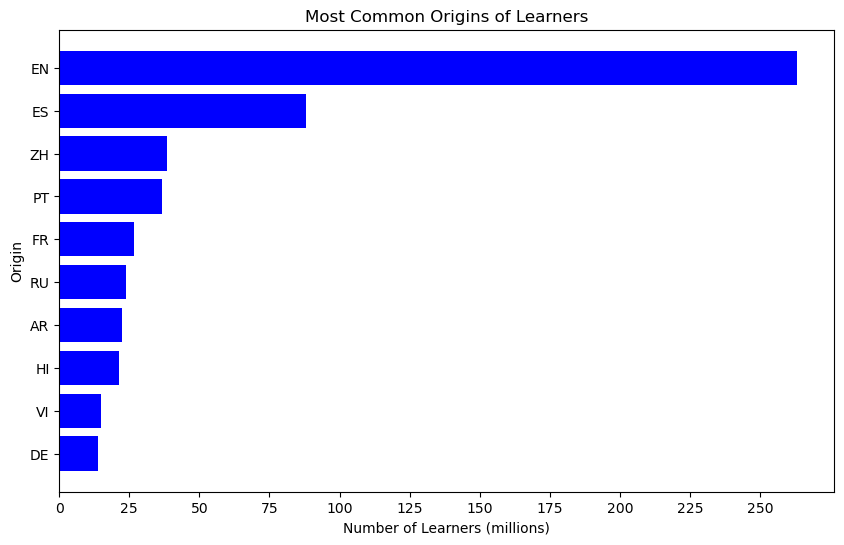

In [119]:
mostcommonorigin = df.groupby("origin")["lr"].sum().sort_values(ascending=False).head(10).iloc[::-1]
# Plotting the most common origins
plt.figure(figsize=(10, 6))
plt.barh(mostcommonorigin.index, mostcommonorigin.values, color="blue")
plt.xlabel("Number of Learners (millions)")
plt.ylabel("Origin")
plt.title("Most Common Origins of Learners")
plt.xticks(range(0, 275, 25))
plt.savefig(os.path.join(image_path, "most_common_origins.png"))
plt.show()


This shows that English is by far the most popular origin language on Duolingo, followed by Spanish and Chinese. This is not surprising, as these languages are spoken by the largest populations in the world.

## Language Pair Popularity

### Who's Learning What?

In [ ]:
import plotly.graph_objects as go

# Grouping the data by origin and learning 
df_grouped = df.groupby(['origin', 'learning'])['lr'].sum().reset_index()

# Filtering so only flows with more than 2 million learners are shown
df_grouped = df_grouped[df_grouped['lr'] > 2]  # filter low-volume flows

# Create list of unique labels
labels = list(set(df_grouped['origin'].tolist() + df_grouped['learning'].tolist()))

# Map labels to indices
label_to_index = {label: i for i, label in enumerate(labels)}
df_grouped['source'] = df_grouped['origin'].map(label_to_index)
df_grouped['target'] = df_grouped['learning'].map(label_to_index)

# Create Sankey Diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=df_grouped['source'],
        target=df_grouped['target'],
        value=df_grouped['lr']
    )
))

fig.update_layout(title_text="Flow of Learners: Origin → Learning Language", font_size=10)
fig.show()


This clearly shows that for every origin language, English is the most popular (or only target with over 3 million) learners. Few countries have multiple origin languages, these include: English, Portuguese, French, Italian, Spanish, Japanese, Korean and Korean. This is likely because people may be choosing to learn a language that is geographically close to them.

To follow on from this graph, I will produce a similar graph, but excluding English as a target language. 

In [121]:
# Creating a Sankey diagram exclusing English as a learning and origin language
df_grouped_no_english = df_grouped[~df_grouped['origin'].isin(['EN']) & ~df_grouped['learning'].isin(['English'])]

# Create Sankey Diagram
fig_no_english = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=df_grouped_no_english['source'],
        target=df_grouped_no_english['target'],
        value=df_grouped_no_english['lr']
    )
))
fig_no_english.update_layout(title_text="Flow of Learners (Excluding English)", font_size=10)
fig_no_english.show()

This graph makes it easier to see which languages people are most likely to learn. From this it appears that people that speak a European language are more likely to learn another European language, and people that speak an Asian language are more likely to learn another Asian language. This is likely due to the fact that these languages are geographically close to each other, and therefore people are more likely to be exposed to them.

### Second Most Popular Target Language
I have chosen to show the second most popular target language for each origin language as for most languages, the most popular target language is English. Looking at the second most popular for each origin might allow us to notice more interesting patterns.

    origin  learning     lr
2       AR    French   3.27
31      DE   Spanish   3.08
49      EN    French  27.60
85      ES    French   7.59
102     FR   Spanish   5.00
140     JA    Korean   2.29
173     PT   Spanish   6.08
185     RU    German   2.94
248     VI   Chinese   2.81
261     ZH  Japanese   6.97


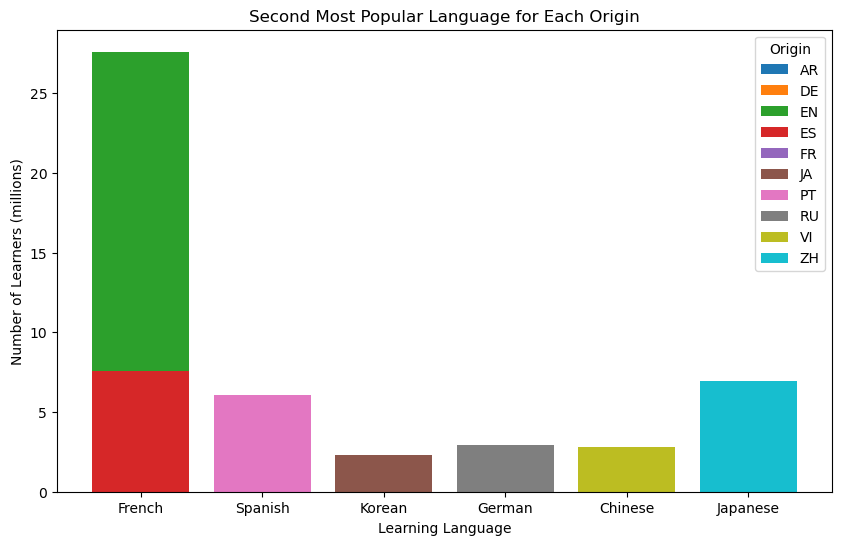

In [ ]:
# Sort by learners (descending) within each origin group
df_grouped_sorted = df_grouped.sort_values(['from', 'Lr'], ascending=[True, False])

# Keep the second entry per origin (i.e., second most popular)
df_second = df_grouped_sorted.groupby('from').nth(1).reset_index()



import plotly.express as px
fig = px.choropleth(

)

### Are people more likely to learn a language of the same family?

In [123]:
lang_to_countries = {
    'en': ['United Kingdom', 'United States', 'Canada', 'Australia', 'New Zealand', 'Ireland', 'South Africa'],
    'es': ['Spain', 'Mexico', 'Argentina', 'Colombia', 'Chile', 'Peru'],
    'fr': ['France', 'Belgium', 'Switzerland', 'Canada', 'Senegal'],
    'pt': ['Portugal', 'Brazil', 'Mozambique', 'Angola'],
    'de': ['Germany', 'Austria', 'Switzerland'],
    'ru': ['Russia', 'Belarus', 'Kazakhstan'],
    'ar': ['Saudi Arabia', 'Egypt', 'United Arab Emirates', 'Morocco', 'Iraq'],
    
}